In [334]:
import numpy as np
import matplotlib.pyplot as plt
import mod_models as mm
import mod_evolution as me
import mod_visualization as mv
import mod_stimulation as ms
from mod_models import logger
import inputools.Trajectory as it
from tqdm import tqdm
from tools.utils import clf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Settings

In [236]:
N = 2
Nj = 6

#### Inputs

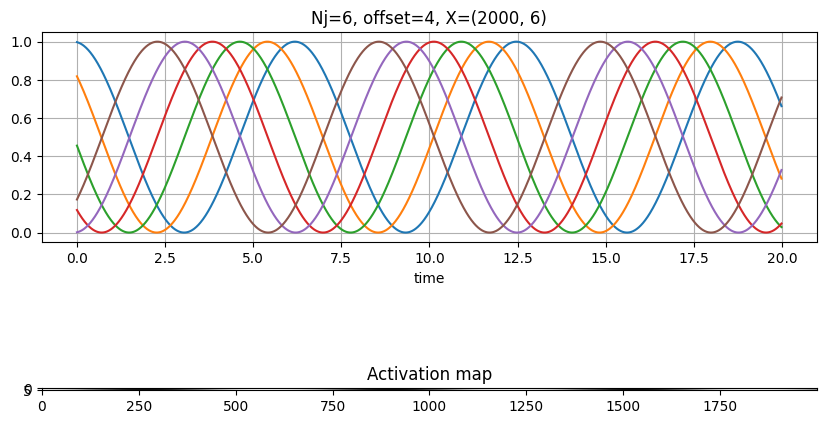

In [412]:
T = 20
dx = 0.01
offset = 4

layer = lambda x: (np.cos(x + np.linspace(1e-1, offset, Nj)) + 1) / 2

Z = np.arange(0, T, dx).reshape(-1, 1)
X = layer(Z)

plt.figure(figsize=(10, 6))

plt.subplot(211)
for x in X.T:
    plt.plot(Z, x)
plt.grid()
plt.title(f"{Nj=}, {offset=}, X={X.shape}") 
plt.xlabel("time")

plt.subplot(212)
plt.title("Activation map")
plt.imshow(X.T, cmap="Greys")
plt.show()


In [561]:
model = mm.RateNetwork2(N=N, Nj=Nj, 
                       gain=4,
                       bias=4,
                       lr_max=0.9,
                       lr_beta=0.85,
                       lr_alpha=0.6,
                       rule='hebb',
                       plastic=True,
                       wff_std=0.01,
                       tau_dw=4,
                       wff_min=0.01,
                       wff_max=2.,
                       wff_const=8,
                       wff_tau=200,
                       is_modulated=True,
                       soft_beta=10)
logger.info(model)

2023-11-17 00:58:09 | RateNetwork2(N=2, Nj=6, rule=hebb)


###### Load model from evolution

In [351]:
genome = me.load_best_individual()
genome

2023-11-16 22:18:37 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-11-16 22:18:37 | 0: best_ind_2341.json
2023-11-16 22:18:37 | 1: best_ind_0002.json
2023-11-16 22:18:37 | 2: best_ind_1853.json
2023-11-16 22:18:37 | 3: best_ind_1939_r.json
2023-11-16 22:18:37 | 4: best_ind_2336.json
2023-11-16 22:18:37 | 5: best_ind_1736.json
2023-11-16 22:18:37 | 6: best_ind_0058.json
2023-11-16 22:18:37 | 7: best_ind_0019.json
2023-11-16 22:18:37 | 8: best_ind_1829.json
2023-11-16 22:18:37 | 9: best_ind_1746.json
2023-11-16 22:18:37 | 10: best_ind_2351.json
2023-11-16 22:18:37 | 11: best_ind_2326_r.json
2023-11-16 22:18:37 | 12: best_2214_r2.json
2023-11-16 22:18:37 | 13: best_ind_2238.json
2023-11-16 22:18:37 | 14: best_ind_2311.json
2023-11-16 22:18:37 | 15: top_ij_1.json
2023-11-16 22:18:37 | 16: best_ind_2312_r.json
2023-11-16 22:18:37 | 17: best_ind_0048.json
2023-11-16 22:18:37 | 18: best_ind_0122.json
2023-11-16 22:18:37 | 19: best_ind_2236.json
2023-11-16 22:18:37 | 20: be

Choose a file:  26


2023-11-16 22:18:48 | Best individual loaded from best_2218_r2.json in /Users/daniekru/Research/lab/PCNN/cache.


{'gain': 17.85,
 'bias': 0.2,
 'lr': 0.00047,
 'tau_dw': 81.1,
 'wff_std': 2.92,
 'wff_max': 6.3,
 'is_modulated': True,
 'rule': 'oja',
 'N': 2,
 'Nj': 6}

In [352]:
model = mm.RateNetwork2(**genome)
logger.info(model)

2023-11-16 22:18:50 | RateNetwork2(N=2, Nj=6, rule=oja)


#### Simulation

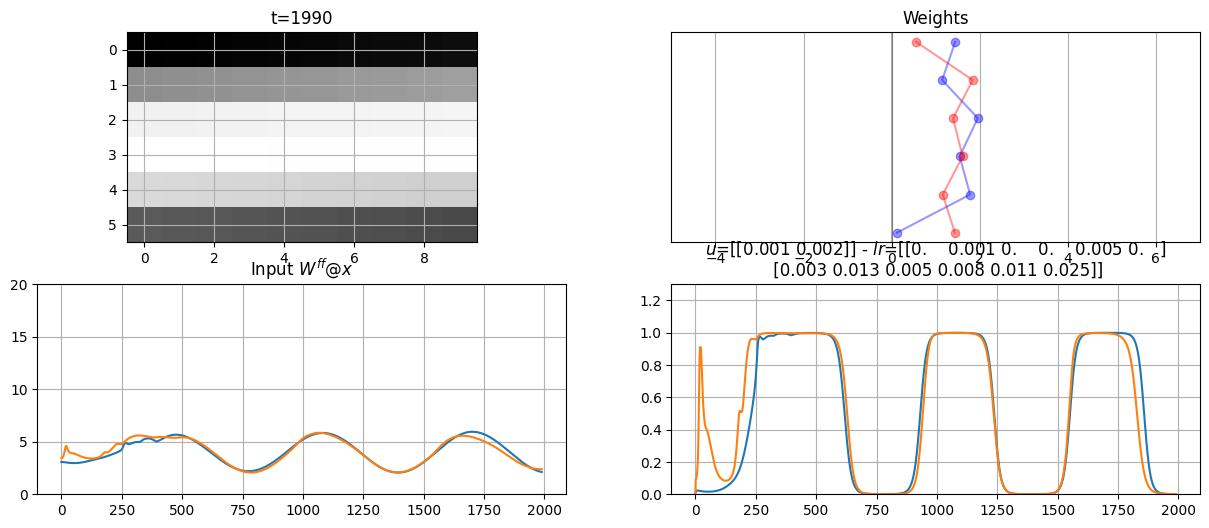

In [562]:
model.reset()


record = np.zeros((4, len(X)))
X2 = np.zeros((len(X) + 10, Nj))

for t, x in enumerate(X):
    
    model.step(x=x.reshape(-1, 1))
    record[0, t] = (model.Wff @ x.reshape(-1, 1))[0]
    record[1, t] = (model.Wff @ x.reshape(-1, 1))[1]
    record[2, t] = model.u[0]
    record[3, t] = model.u[1]
    X2[10:t+10] = X[:t]


    if t % 10 == 0:
        
        clf()
        plt.figure(figsize=(15, 6))
        plt.tight_layout()
        
        plt.subplot(221)
        plt.imshow(X2.T[:, t-10:t], cmap="Greys")
        #plt.ylim((0, 1))
        plt.title(f"{t=}")
        #plt.xlabel("time")
        plt.grid()
        
        plt.subplot(222)
        plt.axvline(0, color='black', alpha=0.3)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), '-b', alpha=0.4)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), 'ob', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), '-r', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), 'or', alpha=0.4)
        plt.title(f"Weights")
        plt.yticks(())
        plt.xlim((-5, 7))
        #plt.xlabel("intensity")
        plt.grid()
        
        plt.subplot(223)
        plt.plot(range(t), record[0, :t])
        plt.plot(range(t), record[1, :t])
        plt.title("Input $W^{ff}$@$x$")
        plt.ylim((0, 20))
        plt.grid()
        
        plt.subplot(224)
        plt.plot(range(t), record[2, :t])
        plt.plot(range(t), record[3, :t])
        plt.title(f"$u$={np.around(model.u.T, 3)} - $lr$={np.around(model._lr, 3)}")
        plt.ylim((0, 1.3))
        plt.grid()
        plt.pause(0.001)

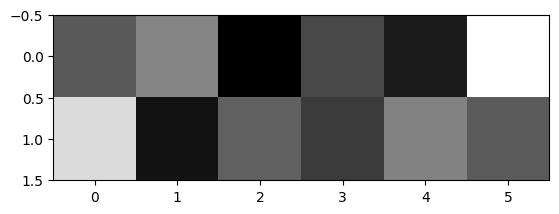

In [563]:
plt.imshow(model.Wff, cmap="Greys");

In [328]:
model.Wff

array([[0.3906318 , 0.4956109 , 0.35404127, 0.05687861, 0.3868284 ,
        1.14821202],
       [1.56580847, 1.41341943, 1.81138881, 3.31874949, 2.02485865,
        1.16071231]])

In [332]:
soft = 

array([[0.4956109 , 1.14821202],
       [2.02485865, 3.31874949]])